In [1]:
import glob
import os
import shutil
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from modules.scandata import MriScan, MriSlice, TumourSegmentation, ScanType, ScanPlane

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython.display import clear_output

2022-11-30 11:19:08.422872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 11:19:08.644683: I tensorflow/core/tpu/tpu_initializer_helper.cc:262] Libtpu path is: libtpu.so
I1130 11:19:08.766714446 2432144 ev_epoll1_linux.cc:121]     grpc epoll fd: 68
D1130 11:19:08.766761144 2432144 ev_posix.cc:141]            Using polling engine: epoll1
D1130 11:19:08.766958807 2432144 lb_policy_registry.cc:43]   registering LB policy factory for "grpclb"
D1130 11:19:08.766989756 2432144 lb_policy_registry.cc:43]   registering LB policy factory for "rls_experimental"
D1130 11:19:08.767052132 2432144 lb_policy_registry.cc:43]   registering LB policy factory for "priority_experimental"
D1130 11:19:08

In [3]:
tf.config.list_logical_devices('TPU')

2022-11-30 11:19:11.087516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 11:19:17.311729: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x797df50 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2022-11-30 11:19:17.311769: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): TPU, 2a886c8
2022-11-30 11:19:17.311776: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): TPU, 2a886c8
2022-11-30 11:19:17.311781: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): TPU, 2a886c8
2022-11-30 11:19:17.311787: I tensorflow/compiler/xla/service/service.cc:181]   

[LogicalDevice(name='/device:TPU:0', device_type='TPU'),
 LogicalDevice(name='/device:TPU:1', device_type='TPU'),
 LogicalDevice(name='/device:TPU:2', device_type='TPU'),
 LogicalDevice(name='/device:TPU:3', device_type='TPU'),
 LogicalDevice(name='/device:TPU:4', device_type='TPU'),
 LogicalDevice(name='/device:TPU:5', device_type='TPU'),
 LogicalDevice(name='/device:TPU:6', device_type='TPU'),
 LogicalDevice(name='/device:TPU:7', device_type='TPU')]

In [4]:
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
strategy = tf.distribute.TPUStrategy(cluster_resolver)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [5]:
batch_size = 64
img_height = 240
img_width = 240
data_dir = os.path.join('data','UPENN-GBM','slice_classification_common_stratify','train')


In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    color_mode="rgba",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 49725 files belonging to 5 classes.
Using 39780 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    color_mode="rgba",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 49725 files belonging to 5 classes.
Using 9945 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['background', 'background_edema', 'background_edema_contrast', 'background_tumour_edema', 'background_tumour_edema_contrast']


In [9]:
 # Calculate class weights ofr weighting accuracy
ds_classes = []
for _, batch_classes in train_ds:
    ds_classes.append(batch_classes.numpy())

ds_classes = np.concatenate(ds_classes)

class_weight = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(ds_classes),
    y=ds_classes
)

class_weight = dict(zip(np.unique(ds_classes), class_weight))


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./(2**8-1))

In [12]:
num_classes = len(class_names)

In [13]:
margin = 8
scaled_height = img_height - 2*margin
scaled_width = img_width - 2*margin

In [14]:
# Build layers for model


In [15]:

with strategy.scope():
    crop_layer = tf.keras.layers.Cropping2D(margin)
    #rescale_initial = tf.keras.layers.Rescaling(1./127.5, offset=-1)
    rescale_initial = tf.keras.layers.Rescaling(1./255)
    conv_4to3_channel = tf.keras.layers.Conv2D(3,1,padding='same', activation='tanh')
    trained_base_model = tf.keras.applications.MobileNetV2(
        input_shape=(scaled_width,scaled_height,3),
        include_top=False,
        weights='imagenet'
    )
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(num_classes)

    trained_base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(img_width, img_height, 4))
    x = crop_layer(inputs)
    x = rescale_initial(x)
    x = conv_4to3_channel(x)
    x = trained_base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
   
    earlystopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
         patience=3,
         min_delta=0.001)
    
    model_fixed_base = tf.keras.Model(inputs, outputs)
    model_fixed_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy']
    )

2022-11-30 11:19:42.214240: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-30 11:19:42.293561: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [16]:
model_fixed_base.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 4)]     0         
                                                                 
 cropping2d (Cropping2D)     (None, 224, 224, 4)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 4)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       15        
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

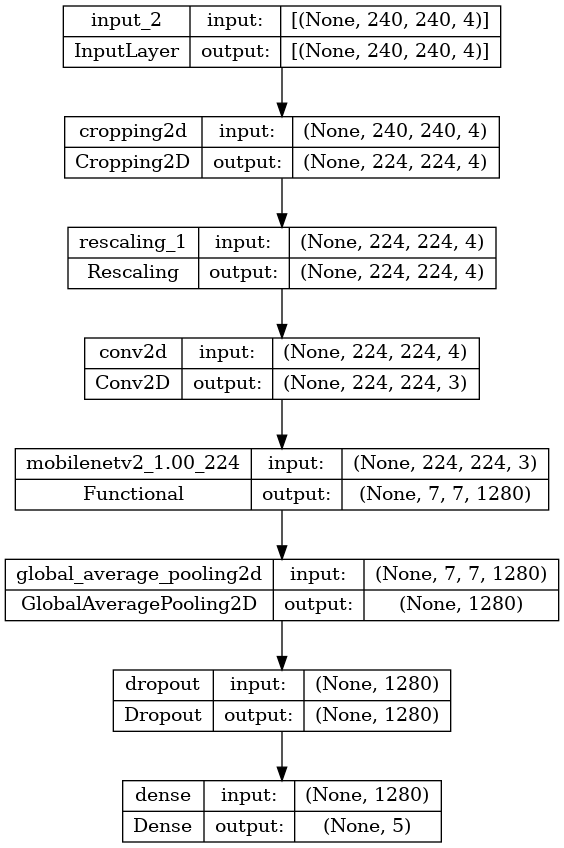

In [17]:
tf.keras.utils.plot_model(model_fixed_base, show_shapes=True)

In [18]:
small_model_epochs=80
history_model_fixed_base = model_fixed_base.fit(
  train_ds,
  validation_data=val_ds,
  epochs=small_model_epochs,
  class_weight=class_weight,
  callbacks=[earlystopping],
)

2022-11-30 11:20:04.324486: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 39780
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}



Epoch 1/80


2022-11-30 11:20:11.014140: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:7508030043732270841
2022-11-30 11:20:11.317162: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-30 11:20:11.626043: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-30 11:20:16.283274: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(383136098441396369), session_name()


  2/622 [..............................] - ETA: 37s - loss: 2.0118 - accuracy: 0.1484    

2022-11-30 11:20:22.494293: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 383136098441396369 with session name  took 6.210683026s and succeeded
2022-11-30 11:20:22.519030: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(383136098441396369), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_7508030043732270841", property.function_library_fingerprint = 14719711814958832020, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "8,240,240,4,;8,;8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-30 11:20:22.519086: I tensorflow/c

603/622 [============================>.] - ETA: 0s - loss: 1.5106 - accuracy: 0.3775

2022-11-30 11:20:47.332219: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(4929269968073737045), session_name()


607/622 [============================>.] - ETA: 0s - loss: 1.5097 - accuracy: 0.3777

2022-11-30 11:20:53.536452: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 4929269968073737045 with session name  took 6.204135025s and succeeded
2022-11-30 11:20:53.562501: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(4929269968073737045), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_7508030043732270841", property.function_library_fingerprint = 14719711814958832020, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "5,240,240,4,;5,;5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-30 11:20:53.562611: I tensorflow

621/622 [============================>.] - ETA: 0s - loss: 1.5118 - accuracy: 0.3786

2022-11-30 11:20:54.287528: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 9945
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:7"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-11-30 

622/622 [==============================] - 65s 76ms/step - loss: 1.5110 - accuracy: 0.3787 - val_loss: 1.3059 - val_accuracy: 0.4420


2022-11-30 11:21:09.702216: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 16409134106131111377 with session name  took 3.687154141s and succeeded
2022-11-30 11:21:09.715913: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(16409134106131111377), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_15450537635097717211", property.function_library_fingerprint = 10383662355163757858, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "4,240,240,4,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-30 11:21:09.715987: I tensorflow/

Epoch 2/80
622/622 [==============================] - 30s 49ms/step - loss: 1.3962 - accuracy: 0.4474 - val_loss: 1.2349 - val_accuracy: 0.5066
Epoch 3/80
622/622 [==============================] - 29s 47ms/step - loss: 1.3234 - accuracy: 0.4720 - val_loss: 1.1955 - val_accuracy: 0.5263
Epoch 4/80
622/622 [==============================] - 30s 48ms/step - loss: 1.3015 - accuracy: 0.4892 - val_loss: 1.1900 - val_accuracy: 0.5221
Epoch 5/80
622/622 [==============================] - 30s 47ms/step - loss: 1.2632 - accuracy: 0.5024 - val_loss: 1.0983 - val_accuracy: 0.5908
Epoch 6/80
622/622 [==============================] - 29s 46ms/step - loss: 1.2307 - accuracy: 0.5174 - val_loss: 1.1434 - val_accuracy: 0.5512
Epoch 7/80
622/622 [==============================] - 29s 46ms/step - loss: 1.2150 - accuracy: 0.5280 - val_loss: 1.1392 - val_accuracy: 0.5424
Epoch 8/80
622/622 [==============================] - 28s 45ms/step - loss: 1.1983 - accuracy: 0.5301 - val_loss: 1.0988 - val_accuracy:

In [19]:
layer_outputs = [layer.output for layer in model_fixed_base.layers[:4]]
vis_model = tf.keras.models.Model(
    inputs=model_fixed_base.input, 
    outputs=layer_outputs
)

In [20]:
#((activations[-1][1,:,:,:]+1)*127.5).astype('uint8')

1/1 [==============================] - 0s 28ms/step


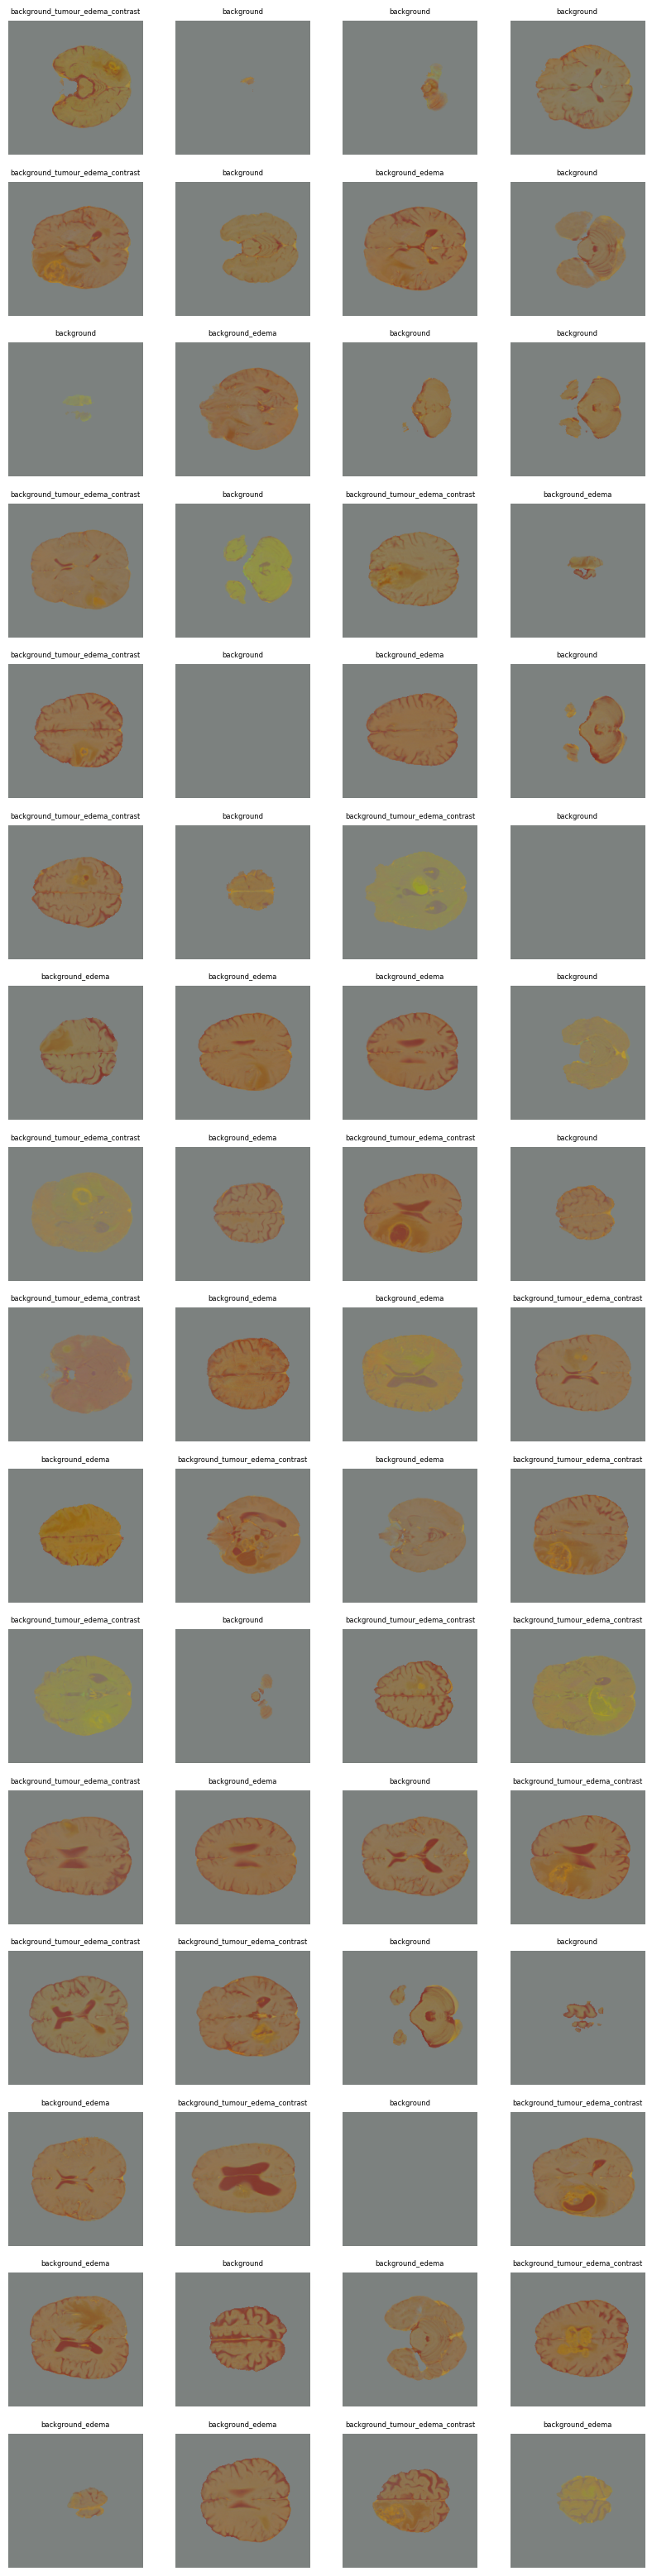

In [21]:
plt.figure(figsize=(10, 40))
batch = train_ds.take(1)
#activations = vis_model.predict(batch)
for images, labels in batch:
  for i in range(64):
    image = np.expand_dims(images[i], axis=0)
    activation = vis_model.predict(image)
    ax = plt.subplot(16, 4, i + 1)
    plt.imshow(((activation[-1][0,:,:,:]+1)*127.5).astype('uint8'))
    plt.title(class_names[labels[i]], fontsize=6)
    plt.axis("off")

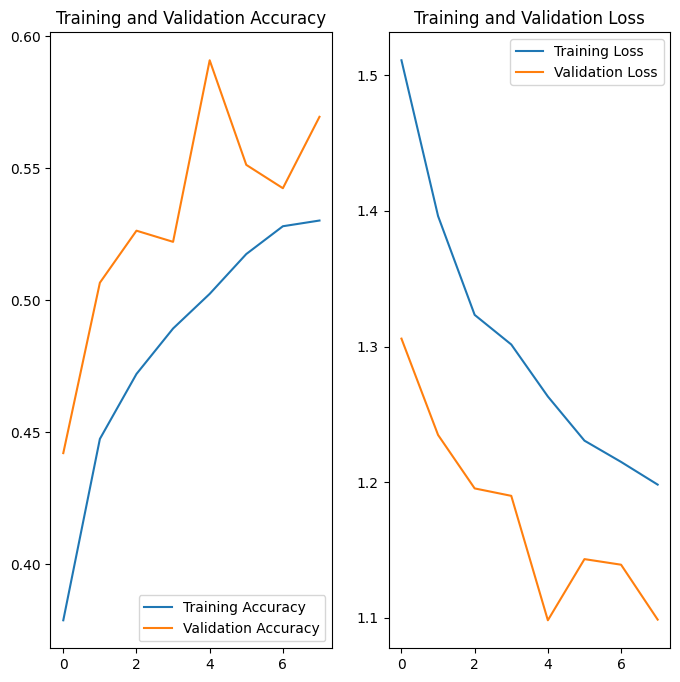

In [22]:
acc = history_model_fixed_base.history['accuracy']
val_acc = history_model_fixed_base.history['val_accuracy']

loss = history_model_fixed_base.history['loss']
val_loss = history_model_fixed_base.history['val_loss']

epochs_range = range(small_model_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
trained_base_model.trainable = True

In [24]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in trained_base_model.layers[:fine_tune_at]:
  layer.trainable = False

KeyboardInterrupt: 

In [ ]:
with strategy.scope():
  model_fixed_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy']
  )

In [ ]:
fine_tuning_epochs=100
total_epochs = small_model_epochs + fine_tuning_epochs
history_fine_tuning = model_fixed_base.fit(
  train_ds,
  validation_data=val_ds,
  epochs=total_epochs,
  initial_epoch=history_model_fixed_base.epoch[-1],
  class_weight=class_weight,
  callbacks=[earlystopping],
)

In [ ]:
layer_outputs = [layer.output for layer in model_fixed_base.layers[:4]]
vis_model = tf.keras.models.Model(
    inputs=model_fixed_base.input, 
    outputs=layer_outputs
)

In [ ]:
plt.figure(figsize=(10, 40))
for images, labels in batch:
  for i in range(64):
    image = np.expand_dims(images[i], axis=0)
    activation = vis_model.predict(image)
    ax = plt.subplot(16, 4, i + 1)
    plt.imshow(((activation[-1][0,:,:,:]+1)*127.5).astype('uint8'))
    plt.title(class_names[labels[i]], fontsize=6)
    plt.axis("off")

In [ ]:
acc_fine = history_fine_tuning.history['val_accuracy']
loss_fine = history_fine_tuning.history['val_loss']
plt.plot(acc_fine)

In [ ]:
trained_base_model.trainable = True
for layer in trained_base_model.layers:
    print(layer.trainable)

In [ ]:
with strategy.scope():
  model_fixed_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy']
  )
  

In [ ]:
full_relax_epochs=100
total_epochs += full_relax_epochs
history_fine_tuning = model_fixed_base.fit(
  train_ds,
  validation_data=val_ds,
  epochs=total_epochs,
  initial_epoch=history_fine_tuning.epoch[-1],
  class_weight=class_weight,
  callbacks=[earlystopping],
)

In [ ]:
layer_outputs = [layer.output for layer in model_fixed_base.layers[:4]]
vis_model = tf.keras.models.Model(
    inputs=model_fixed_base.input, 
    outputs=layer_outputs
)

plt.figure(figsize=(10, 40))
#batch = train_ds.take(1)
#activations = vis_model.predict(batch)
for images, labels in batch:
  for i in range(64):
    image = np.expand_dims(images[i], axis=0)
    activation = vis_model.predict(image)
    ax = plt.subplot(16, 4, i + 1)
    plt.imshow(((activation[-1][0,:,:,:]+1)*127.5).astype('uint8'))
    plt.title(class_names[labels[i]], fontsize=6)
    plt.axis("off")

In [ ]:
for ch in range(3):

    print(
        (((activation[-1][:,:,:,ch]+1)*127.5).astype('uint8')).min(), 
        (((activation[-1][:,:,:,ch]+1)*127.5).astype('uint8')).max(), 
    )

In [ ]:
model_fixed_base.summary()

In [ ]:
tf.keras.utils.plot_model(trained_base_model)

In [ ]:
with strategy.scope():
    # Use the activations of these layers
    pretrained_layer_name='mobilenetv2_1.00_224'
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    base_model_outputs = [
        model_fixed_base.get_layer(pretrained_layer_name)
        .get_layer(name).output for name in layer_names
    ]

    # Create the feature extraction model
    down_stack = tf.keras.Model(
        inputs=model_fixed_base.get_layer(pretrained_layer_name).input, 
        outputs=base_model_outputs
    )

    down_stack.trainable = False

In [ ]:
down_stack.summary()

In [ ]:
#for layer in model_fixed_base.get_layer(pretrained_layer_name).layers[:-4]:
#    down_stack.get_layer(layer.name).set_weights(layer.get_weights())

In [ ]:
#down_stack.set_weights(model_fixed_base.get_layer(pretrained_layer_name).get_weights())

In [ ]:
tf.keras.utils.plot_model(down_stack, show_shapes=True)

In [ ]:

# Define each layer block for upbranch
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.

  Conv2DTranspose => Batchnorm => Dropout => Relu

  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer

  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  #elif norm_type.lower() == 'instancenorm':
  #  result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


In [ ]:
up_stack = [
    upsample(512, 3),  # 7x7 -> 14x14
    upsample(256, 3),  # 14x14 -> 28x28
    upsample(128, 3),  # 28x28 -> 56x56
    upsample(64, 3),   # 56x56 -> 112x112
]

In [ ]:
for layer in model_fixed_base.layers[1:4]:
    print(layer.name)

In [ ]:
tensor = tf.convert_to_tensor(np.random.rand(64,240,240,4))
tensor

In [ ]:
#model.layers[2].input

In [ ]:
def unet_model(output_channels: int):

    # Add layers from classification model
    inputs = tf.keras.layers.Input(shape=[240, 240, 4])
    x = model_fixed_base.layers[1](inputs)
    for layer in model_fixed_base.layers[2:4]:
        x = layer(x)

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last_conv_trans = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2, padding="same"
    )  # 64x64 -> 128x128

    x = last_conv_trans(x)

    x = tf.keras.layers.ZeroPadding2D(8)(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [ ]:
OUTPUT_CLASSES = 4
with strategy.scope():
    model = unet_model(output_channels=OUTPUT_CLASSES)
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
  
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
images = []
maps = []

train_image_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify','train','image_data')
train_map_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify','train','map_data')

pixel_counts = [0,0,0,0]

for image_file in os.listdir(train_image_dir):
    map_file = image_file.replace('allseq', 'map')
    if not os.path.exists(os.path.join(train_map_dir,map_file)):
        raise FileNotFoundError((image_file, map_file))

    image = tf.io.read_file(os.path.join(train_image_dir,image_file))
    image = tf.io.decode_png(image, channels=4)
    seg_map = tf.io.read_file(os.path.join(train_map_dir,map_file))
    seg_map = tf.io.decode_png(seg_map, channels=1)

    # Convert map to make class integers contiguous
    seg_map = seg_map.numpy()
    seg_map[seg_map==4] = 3
    seg_map = tf.convert_to_tensor(seg_map)

    # Count pixel classes
    indices,counts = np.unique(map,return_counts=True)
    for i, index in enumerate(indices):
        pixel_counts[index] += counts[i]
    
    images.append(image)
    maps.append(seg_map)

In [ ]:
train_images, val_images, train_maps, val_maps = train_test_split(images, maps, test_size=0.2)
train_images = tf.convert_to_tensor(train_images)
train_maps = tf.convert_to_tensor(train_maps)
val_images = tf.convert_to_tensor(val_images)
val_maps = tf.convert_to_tensor(val_maps)

In [ ]:
val_images.shape

In [ ]:
def scaler_0_1(x):
    return x/255.0

def scaler_neg1_1(x):
    return x/127.5 - 1

def create_dataset(img, seg_map, scaler):
    img = scaler(tf.cast(img, tf.float32))
    
    return img,seg_map

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(
    create_dataset(train_images,train_maps,scaler_neg1_1)
)
val_data = tf.data.Dataset.from_tensor_slices(
    create_dataset(val_images,val_maps,scaler_neg1_1)
)

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [ ]:
train_batch = (
    train_data.cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
val_batch = val_data.batch(BATCH_SIZE)

In [ ]:
for images, masks in train_batch.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])
    print(images.shape, masks.shape)

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# Calculate class weights
weights = 1.0/np.array(pixel_counts)
weights = weights/np.sum(weights)

def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  #class_weights = tf.constant([2.0, 2.0, 1.0])
  #class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [ ]:
TRAIN_LENGTH=68076
EPOCHS = 40
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 17019//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_batch.map(add_sample_weights), 
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_batch,
    callbacks=[DisplayCallback()],
)

In [ ]:
model_history.history

In [ ]:
#val_maps.shape
plt.imshow(val_images[10,:,:,1],cmap='gist_gray')

In [ ]:
single_img = tf.expand_dims(val_images[10],0)
single_map = tf.expand_dims(val_maps[10],0)


In [ ]:
single_img.shape

In [ ]:
single_ds = tf.data.Dataset.from_tensor_slices(([single_img],[single_map]))


In [ ]:
for simg, smap in single_ds:
    print(simg.shape, smap.shape)

In [ ]:
show_predictions(single_ds)

In [ ]:
weight = tf.constant([2,10,100])

In [ ]:
arr = np.array([[0,0,0],[0,1,0],[0,1,2]])

In [ ]:
print(arr)

In [ ]:
sample_weights = tf.gather(weight, indices=tf.cast(arr, tf.int32))
sample_weights